In [98]:
import pandas as pd 
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from matplotlib.gridspec import GridSpec
plt.rcParams['font.family'] = 'Arial'

from selenobot.files import XMLFile
from selenobot.utils import seed 
from selenobot.datasets import Dataset, get_dataloader
from selenobot.utils import digitize, groupby, sample
import os
import sys
from typing import List, Tuple, Dict
import scipy.stats
import sklearn.neighbors
from tqdm import tqdm
from scipy.stats import false_discovery_control, mannwhitneyu

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
label_names = dict()
label_names[0] = 'full-length'
label_names[1] = 'trunc. sel.'
label_names[2] = 'short full-len.'

color_map = {1:'tab:red', 2:'tab:blue', 0:'tab:green'}
color_map.update({'train':'tab:red', 'test':'tab:blue', 'val.':'tab:green'})

datasets = ['train', 'test', 'val.']

In [100]:
metadata_3c = dict()
metadata_3c['train'] = pd.read_csv('../data/3c_metadata_train.csv', index_col=0)
metadata_3c['test'] = pd.read_csv('../data/3c_metadata_test.csv', index_col=0)
metadata_3c['val.'] = pd.read_csv('../data/3c_metadata_val.csv', index_col=0)

metadata_2c = dict()
metadata_2c['train'] = pd.read_csv('../data/2c_metadata_train.csv', index_col=0)
metadata_2c['test'] = pd.read_csv('../data/2c_metadata_test.csv', index_col=0)
metadata_2c['val.'] = pd.read_csv('../data/2c_metadata_val.csv', index_col=0)

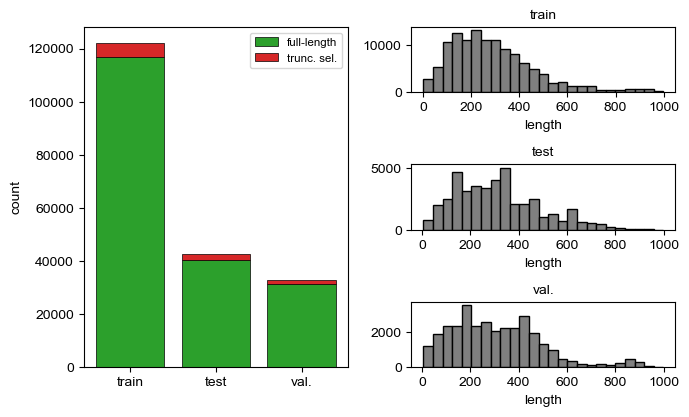

In [101]:
def figure_1(metadata:dict):
    '''Illustrating the composition of each split dataset.'''

    fig = plt.figure(layout='tight', figsize=(7, 8))
    grid = GridSpec(6, 2, figure=fig)

    ax_1a = fig.add_subplot(grid[:3, 0])
    ax_1b = [fig.add_subplot(grid[i, 1]) for i in range(0, 3)]

    labels = metadata['train'].label.unique()

    positions = np.arange(3)
    bottom = np.zeros(3)
    for label in labels:
        heights = np.array([(metadata[dataset]['label'] == label).sum() for dataset in datasets])
        ax_1a.bar(positions, heights, bottom=bottom, color=label_colors[label], edgecolor='black', lw=0.5)
        bottom += heights 

    ax_1a.set_ylabel('count')
    ax_1a.set_xticks(positions, datasets)
    ax_1a.legend([label_names[label] for label in labels], loc='upper right', fontsize='small')

    for ax, dataset in zip(ax_1b, datasets):
        ax.hist(metadata[dataset].seq.apply(len), bins=25, lw=0.5, edgecolor='black', color='gray')
        ax.set_title(dataset, fontsize='medium')
        # ax.set_ylabel('count')
        ax.set_xlabel('length')
    
    plt.show()


figure_1(metadata_2c)




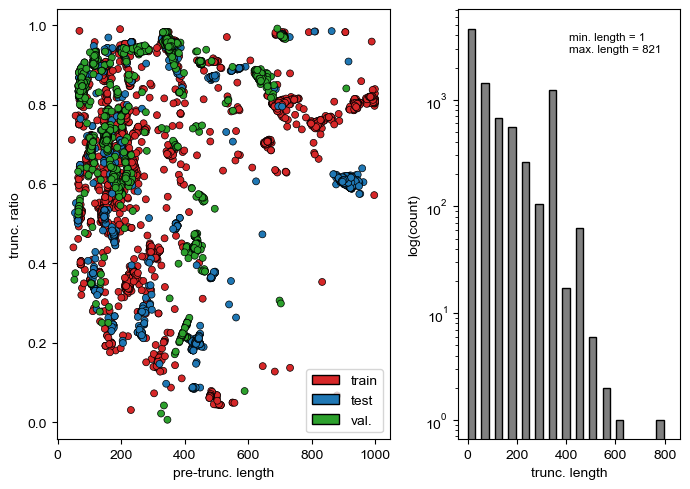

In [102]:
# What are the truncation ratio distributions for the selenoprotein? How short is the shortest one?

metadata_2c_1_df = pd.concat([df[df.label == 1].assign(dataset=dataset) for dataset, df in metadata_2c.items()]) # Grab all truncated selenoproteins. 
metadata_2c_0_df = pd.concat([df[df.label == 0].assign(dataset=dataset) for dataset, df in metadata_2c.items()]) # Grab all truncated selenoproteins. 

fig, axes = plt.subplots(ncols=2, figsize=(7, 5), width_ratios=[0.6, 0.4], layout='tight')

ax = axes[0]

colors = metadata_2c_1_df.dataset.replace(color_map).values
ax.scatter(metadata_2c_1_df.original_length, metadata_2c_1_df.truncation_ratio, s=25, c=colors, edgecolors='black', lw=0.5)
ax.set_xlabel('pre-trunc. length')
ax.set_ylabel('trunc. ratio')
ax.legend(handles=[Patch(facecolor=color_map[dataset], label=dataset, edgecolor='black') for dataset in datasets], loc='lower right')

ax = axes[1]
ax.hist(metadata_2c_1_df.seq.apply(len), bins=15, width=30, edgecolor='black', color='gray')
ax.set_ylabel('log(count)')
ax.set_xlabel('trunc. length')
ax.set_yscale('log')
ax.text(0.5, 0.9, f'min. length = {metadata_2c_1_df.seq.apply(len).min()}\nmax. length = {metadata_2c_1_df.seq.apply(len).max()}', transform=ax.transAxes, fontsize='small')

plt.show()

In [103]:
metadata_2c_0_df['length'] = metadata_2c_0_df.seq.apply(len)
metadata_2c_0_df[metadata_2c_0_df.length < 10].sort_values('length')[['length', 'existence', 'mmseqs_cluster']]

,length,existence,mmseqs_cluster
id,,,


In [104]:
print(len(metadata_2c_1_df))

9017
